In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grupo-bimbo-inventory-demand/town_state.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/train.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/sample_submission.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/producto_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/cliente_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/test.csv.zip


<div style="border-radius:10px; padding: 12px; background-color: #ffffff; font-size:130%; text-align:left">

<h2 align="left"><font color=#E1B12D>Introduction</font></h2>

Grupo Bimbo, a leading multinational bakery company, faces a unique challenge in managing the inventory of its products. With a typical shelf life of just one week, the accuracy of daily inventory calculations is paramount. Currently, these calculations are performed by direct delivery sales employees who rely on their personal experiences to predict the forces of supply, demand, and consumer behavior at each store. The margin for error in this process is minimal. Underestimating demand results in empty shelves and lost sales, while overestimating demand leads to excess product returns and increased expenses.

Grupo Bimbo aims to create a predictive model that can accurately forecast inventory needs based on historical data, thereby optimizing the supply chain and improving efficiency.

<h2 align="left"><font color=#E1B12D>Approach</font></h2>

<a id="toc"></a>
- [1.1 Import Libraries](#1.1)
- [1.2 Configuration](#1.2)
- [1.3 Important Functions](#1.3)
- [1.4 Import Data](#1.4)
- [1.5 Quick overview](#1.5)
- [2. Exploratory Data Analysis ](#2)
- [3.1 Feature Engineering](#3.1)
- [3.2 Missing Data Handling](#3.2)
- [3.3 Outlier Handling](#3.3)
- [3.4 Feature Transformation](#3.4)
- [3.5 Feature Creation](#3.5)
- [3.6 Feature Selection](#3.6)
- [4. Data Pipeline](#4)
- [4.1 Pipeline Creation](#4.1)
- [4.2 Visualizing the Pipeline ](#4.2)
- [5. Model Building](#5)
- [5.1 Train Test Split](#5.1)
- [5.2 Training the Model](#5.2)
- [5.3 Performance Evaluation](#5.3)
- [5.4 Ensembling for Performance Improvement](#5.4)
- [5.5 Model Explainability](#5.5)
- [6. Model Infrence](#6)
- [6.1 Loading the Model](#6.1)
- [6.2 Data Loading and Prepration](#6.2)
- [6.3 Model Forecasting](#6.3)

<a id="1.1"></a>
## <b>1.1 <span style='color:#E1B12D'>Import Libraries</span></b> 

In [2]:
!pip3 install -q dagshub
!pip3 install -q mlflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, but you have aiohttp 3.9.1 which is incompatible.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
cudf 24.4.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
jupyterlab 4.2.1 requires httpx>=0.25.0, but y

In [3]:
# System related tasks
import os
import gc
import warnings

# Data manipulation and numerical operations
import numpy as np 
import pandas as pd  
import polars as pl

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Scikit-learn model selection and evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

# Gradient boosting frameworks
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor

# Optimization and utilities
import optuna
import joblib
from kaggle_secrets import UserSecretsClient

# For Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Experiment tracking and collaboration
import dagshub
import mlflow

# Model Explainability 
import shap

# Ensure warnings are ignored and plots are displayed inline
warnings.filterwarnings('ignore')


<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Configuration</span></b> 

In [4]:
class CFG:
    """
    Configuration class for parameters, models, paths, and cross-validation strategies.
    Please use caps lock for variable names while filling in parameters.
    """
    # Paths
    BASE_PATH = "/kaggle/input/grupo-bimbo-inventory-demand"
    TRAIN_PATH = f"{BASE_PATH}/train.csv.zip"
    TEST_PATH = f"{BASE_PATH}/test.csv.zip"
    
    # Columns Rename to ensure names are readable and relevant
    COLUMN_RENAME = {
        'Semana': 'Week', 
        'Agencia_ID': 'Sales_Depot_ID', 
        'Canal_ID': 'Sales_Channel_ID', 
        'Ruta_SAK': 'Route_ID', 
        'Cliente_ID': 'Client_ID',
        'Producto_ID': 'Product_ID', 
        'Venta_uni_hoy': 'Sales_unit_this_week', 
        'Venta_hoy': 'Sales_this_week', 
        'Dev_uni_proxima': 'Returns_unit_next_week',
        'Dev_proxima': 'Returns_next_week', 
        'Demanda_uni_equil': 'Adjusted_Demand', 
        'NombreCliente': 'Client_name', 
        'NombreProducto': 'Product_Name',
        'Town': 'Town', 
        'State': 'State'
    }
    
    # Data Type Casting Settings to ensure smoth pipeline operation
    DATA_TYPES = {
        'Week': 'float64',
        'Sales_Depot_ID': 'category',
        'Sales_Channel_ID': 'category',
        'Route_ID': 'category',
        'Client_ID': 'category',
        'Product_ID': 'category',
        'Sales_unit_this_week': 'int64',
        'Sales_this_week': 'int64',
        'Returns_unit_next_week': 'int64',
        'Adjusted_Demand': 'int64'
    }
    # Selecting Categorical variable. Client_ID is excluded due to high dimensionality
    
    CATEGORICAL_VARIABLES = ('Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Product_ID')
    # Defining Target Variable 
    
    TARGET_VARIABLE = 'Adjusted_Demand'
    
    # Model Settings to train the model with hyperparameters
    MODELS = {
        "xgboost": {
            "model": xgb.XGBRegressor,
            "params": {
                "n_estimators": 100,
                "max_depth": 8,
                "learning_rate": 0.1,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "tree_method": "gpu_hist", 
                "enable_categorical": True,
                "gpu_id": 0 
            }
        },
        "catboost": {
            "model": CatBoostRegressor,
            "params": {
                "iterations": 100,
                "learning_rate": 0.1,
                "depth": 8,
                "verbose": False,
                "task_type": "GPU", 
                "devices": '0:1' 
            }
        },
        "lightgbm": {
            "model": lgb.LGBMRegressor,
            "params": {
                "n_estimators": 50,
                "learning_rate": 0.1,
                "max_depth": 8,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "device": "cpu", 
                "gpu_device_id": 0,
                "max_bin": 16, 
                "num_leaves": 16,
                "verbosity": -1 
            }
        }
    }

    
    # Cross-Validation Settings for timeseries problem
    CV_STRATEGY = {TimeSeriesSplit(n_splits=2)
    }
    
    # MLflow Settings to track the performance of model training
    MLFLOW_TRACKING_URI = "https://dagshub.com/agshiv92/GrupoBimbo_InventoryDemand_Solutions.mlflow"
    MLFLOW_EXPERIMENT_NAME = "Group_Bimbo_Predictive_Model"
    DAGSHUB_REPO_OWNER = "agshiv92"
    DAGSHUB_REPO = "GrupoBimbo_InventoryDemand_Solutions"
    MLFLOW_URI = "https://dagshub.com/username/repository_name.mlflow"
    MLFLOW_LOCAL_URI = "/kaggle/working/mlflow"
    # Setting seeed to ensure reproducibillity
    SEED=42
    # Model Save Path 
    MODEL_SAVE_PATH = '/kaggle/working/models'
    EXPERIMENT_RECORDING = 'LOCAL'
    

<a id="1.3"></a>
## <b>1.3 <span style='color:#E1B12D'>Important Functions </span></b> 

In [5]:
# Defining some important function which will be used for the analysis of data
def inspect_columns(df, df_name):
    """A helper function that does a better job than df.info() and df.describe()"""
    
    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })
    
    # Print the name of the dataframe
    print(f"\n{'='*10} {df_name} {'='*10}\n")
    
    # Print the head of the dataframe
    print("First few rows of the dataframe:\n")
    display(df.head())
    
    # Print the resulting statistics
    print("Detailed statistics:\n")
    display(result)
    
def cast_data_types(df, data_types):
    """A helper function to cast the pre determined data type for the columns in dataframe"""
    for column,data_type in data_types.items():
        if column in df.columns:
            df[column] = df[column].astype(data_type)
    return df

def get_or_create_experiment_id(name):
    """Function to create or get the experiment id"""
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
        exp_id = mlflow.create_experiment(name)
        return exp_id
    return exp.experiment_id

def reduce_memory_usage(df):
    """Reduce memory usage of a dataframe by downcasting data types."""
    start_mem = df.memory_usage().sum() / 1024**2
#     print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        # Skip timestamp columns
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue
        if (col_type != object) & (col_type != object):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
#     print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

def check_and_create_directory(directory_path):
    """ To create directory if not exist"""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


<a id="1.4"></a>
## <b>1.4 <span style='color:#E1B12D'>Import Data</span></b> 

In [6]:
# Load datasets
train_df = pd.read_csv(CFG.TRAIN_PATH, compression='zip')

<a id="1.5"></a>
## <b>1.5 <span style='color:#E1B12D'>Quick overview</span></b> 

In [7]:
inspect_columns(train_df,"Training Dataframe")


========== Training Dataframe ==========

First few rows of the dataframe:



,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


Detailed statistics:



,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
Semana,74180464,0,False,7,False,0.0,3.00,7.00,9.0,int64
Agencia_ID,74180464,0,False,552,False,0.0,1110.00,1138.00,25759.0,int64
Canal_ID,74180464,0,False,9,False,0.0,7.00,1.00,1.0,int64
Ruta_SAK,74180464,0,False,3603,False,0.0,3301.00,4405.00,5517.0,int64
Cliente_ID,74180464,0,False,880604,False,0.0,15766.00,1064931.00,4708097.0,int64
Producto_ID,74180464,0,False,1799,False,0.0,1212.00,35516.00,43159.0,int64
Venta_uni_hoy,74180464,0,False,2116,False,0.0,3.00,3.00,1.0,int64
Venta_hoy,74180464,0,False,78140,False,0.0,25.14,16.38,10.4,float64
Dev_uni_proxima,74180464,0,False,558,False,0.0,0.00,0.00,0.0,int64
Dev_proxima,74180464,0,False,14707,False,0.0,0.00,0.00,0.0,float64




#### About Data:
    
The dataset provided about Grupo Bimbo. It consists of 7 million records, capturing weekly sales transactions and returns.

#### Columns Description

- **Semana**: Week number (From Thursday to Wednesday). This temporal feature helps identify seasonal and weekly trends in sales and demand.
- **Agencia_ID**: Sales Depot ID. Each depot serves as a distribution point for products and is identified by a unique ID.
- **Canal_ID**: Sales Channel ID. Represents the sales channel through which products are sold, such as retail, wholesale, etc.
- **Ruta_SAK**: Route ID. Indicates the delivery route for sales depots. Multiple routes can exist within a single sales depot.
- **Cliente_ID**: Client ID. Unique identifier for each client.
- **NombreCliente**: Client name. Descriptive name of the client associated with the Client ID.
- **Producto_ID**: Product ID. Unique identifier for each product.
- **NombreProducto**: Product Name. Descriptive name of the product associated with the Product ID.
- **Venta_uni_hoy**: Sales units this week. Represents the number of units sold for a given product within the week.
- **Venta_hoy**: Sales this week in pesos. Represents the total sales in monetary units for a given product within the week.
- **Dev_uni_proxima**: Returns units next week. Indicates the number of units returned for a given product in the following week.
- **Dev_proxima**: Returns next week in pesos. Represents the total monetary value of returned products in the following week.
- **Demanda_uni_equil**: Target variable for prediction, representing the adjusted demand for a given product.

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
<a id="2"></a>
## <b>2 <span style='color:#E1B12D'> Exploratory Data Analysis</span></b> 

EDA for this is available here https://www.kaggle.com/code/agshiv92/group-bimbo-eda

<a id="3"></a>
## <b>3 <span style='color:#E1B12D'> Feature Engineering </span></b> 
### <b>3.1 <span style='color:#E1B12D'> Missing Data Handling </span></b> 

There is no missing data in the dataframe. If there are missing data there are there are below methods to handle missing data. 

### Handling Missing Data

1. **Remove Missing Data**
   - Remove rows with missing values
   - Remove columns with missing values

2. **Impute Missing Data**
   - **Mean Imputation**: Replace missing values with the mean.
   - **Median Imputation**: Replace missing values with the median.
   - **Mode Imputation**: Replace missing values with the mode.
   - **Forward Fill**: Replace missing values with the previous value.
   - **Backward Fill**: Replace missing values with the next value.
   - **Interpolation**: Use linear interpolation to estimate missing values.
   - **K-Nearest Neighbors (KNN) Imputation**: Use the nearest neighbors to impute missing values.
   - **Predictive Imputation**: Use regression or other models to predict missing values.


<a id="3.2"></a>
### <b>3.2 <span style='color:#E1B12D'> Outlier Handling </span></b> 

<Figure size 1200x600 with 0 Axes>

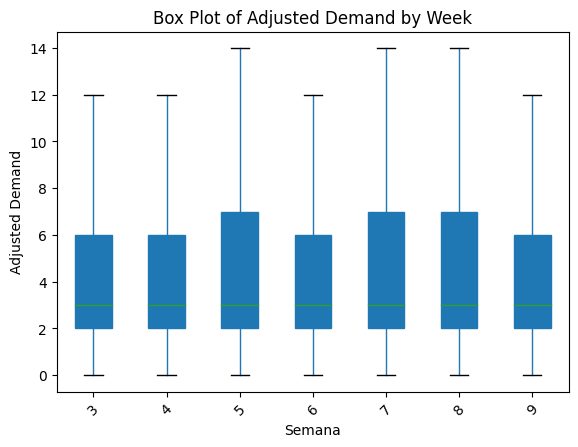

In [10]:
plt.figure(figsize=(12, 6))
train_df.boxplot(column='Demanda_uni_equil', by='Semana', grid=False, showfliers=False, patch_artist=True)
plt.title('Box Plot of Adjusted Demand by Week')
plt.suptitle('')  
plt.xlabel('Semana')
plt.ylabel('Adjusted Demand')
plt.xticks(rotation=45)
plt.show()

<a id="3.3"></a>
### <b>3.3 <span style='color:#E1B12D'> Feature Transformation </span></b> 

#### 3.3.0 Data Prepration
Data prepration by giving appropriate column name and converting the data in appropriate data type

In [18]:
def prepare_data(df):
    df = cast_data_types(df, CFG.DATA_TYPES)
    df = df.rename(CFG.COLUMN_RENAME,axis=1)
    if 'Adjusted_Demand' not in df.columns: # To take care of Prediction
        df['Adjusted_Demand']=0
    #Assuming Week 1 starts from 1st January 2024
    if 'Week' in df.columns:
        df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(df['Week'].astype(int) * 7, unit='D')
    df = reduce_memory_usage(df)
    return df
train_df = prepare_data(train_df)

Decreased by 58.0%


#### 3.3.1 One Hot Encoding

I have chosen to avoid one-hot encoding for categorical variables. Instead, I will be leveraging advanced machine learning algorithms like LightGBM, which natively support categorical data. This decision is driven by three key factors:- Efficiency, Performance and 
Simplicity

#### 3.3.2 Lagged Features
Lagged features are the demand in previouse week for the same product and client. This feature is helpful to understand the dempendency of the demand on previous history

In [19]:
def lagged_feature_creation_demand(df):
    df = df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID', 'Week'])
    df['Lagged_Demand_1'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(1)
    df['Lagged_Demand_2'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(2)
    df['Lagged_Demand_3'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(3)
    df = reduce_memory_usage(df)
    gc.collect() 
    return df
train_df = lagged_feature_creation_demand(train_df)

Decreased by 26.1%


In [20]:
def lagged_feature_creation_return(df):
    df = df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID', 'Week'])
    df['Lagged_Return_1'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(1)
    df['Lagged_Return_2'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(2)
    df['Lagged_Return_3'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(3)
    df = reduce_memory_usage(df)
    gc.collect()
    return df
train_df = lagged_feature_creation_return(train_df)

Decreased by 24.0%


#### 3.3.3 Rolling Features
Rolling features capture the aggregated values over a specific window of time, such as the average or sum of demand over the past few weeks. These features are instrumental in understanding trends and patterns in the data.


In [21]:
# Convert to Polars DataFrame
def rolling_feature_creation(df, window):
    window_size = window
    df_pl = pl.DataFrame(df.reset_index())
    df_pl = df_pl.with_columns([pl.col("Adjusted_Demand").cast(pl.Float32)])
    df_pl_lazy = df_pl.lazy()
    # Apply rolling calculations
    df_pl_lazy = df_pl_lazy.with_columns([
        pl.col("Lagged_Demand_1").rolling_mean(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Mean_3"),
        pl.col("Lagged_Demand_1").rolling_sum(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Sum_3"),
        pl.col("Lagged_Demand_1").rolling_std(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Std_3")
    ])
    # Collect the result
    df_pl_optimized = df_pl_lazy.collect()
    df = df_pl_optimized.to_pandas()
    
    # Clean up
    del df_pl_optimized
    del df_pl
    del df_pl_lazy
    gc.collect()
    # Reduce memory usage and fill NaN values
    df = reduce_memory_usage(df)
    gc.collect()
    df = df.fillna(0)
    return df
train_df = rolling_feature_creation(train_df,3)

Decreased by 28.9%


<a id="3.4"></a>
### <b>3.4 <span style='color:#E1B12D'> Feature Creation </span></b> 

#### 3.4.1 Sales Growth

In [22]:
def sales_growth(df):
    df['Sales_Growth_Rate_1'] = (df['Lagged_Demand_1'] - df['Lagged_Demand_2']) / df['Lagged_Demand_1']
    df['Sales_Growth_Rate_2'] = (df['Lagged_Demand_2'] - df['Lagged_Demand_3']) / df['Lagged_Demand_2']
    return df
train_df = sales_growth(train_df)

#### 3.4.2 Client Total Sales

In [23]:
def client_total_sales(df):
    client_sales = df.groupby(['Client_ID','Week'])['Lagged_Demand_1'].sum().reset_index().rename(columns={'Lagged_Demand_1': 'Total_Sales_per_Client'}).copy()
    df = df.merge(client_sales, on=['Client_ID','Week'], how='left')
    return df
train_df = client_total_sales(train_df)

In [24]:
def final_processing(df,categorical_vairable):
    df = df.replace([np.inf, -np.inf], np.nan) # Replacing infinite values with Nan
    df = df.fillna(0) # Filling na with 0
    df.set_index('Week', inplace=True)
    for col in categorical_vairable:
        df[col] = df[col].astype('category')       
    df = df.drop(['index','Sales_unit_this_week', 'Sales_this_week','Returns_unit_next_week', 'Returns_next_week'],axis=1)
    return df
train_df = final_processing(train_df,CFG.CATEGORICAL_VARIABLES)

<a id="3.5"></a>
### <b>3.5 <span style='color:#E1B12D'> Feature Selection </span></b> 

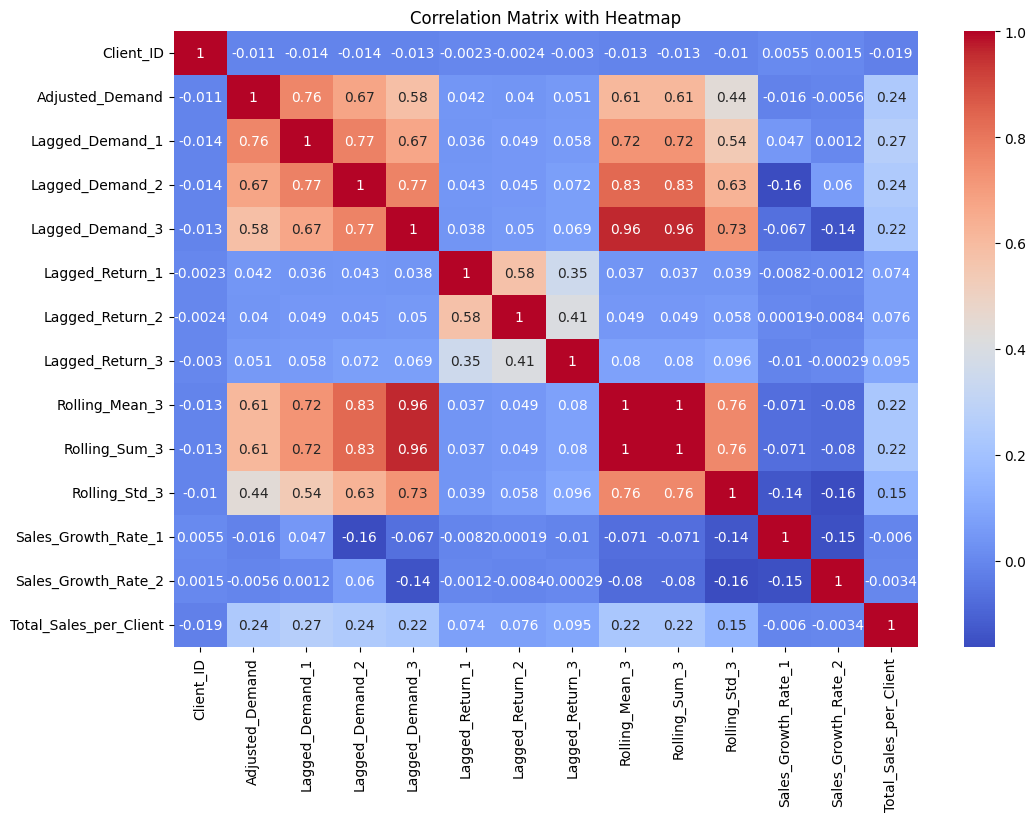

In [25]:
numeric_columns = [col for col in train_df.columns if col not in CFG.CATEGORICAL_VARIABLES]
corr_matrix = train_df[numeric_columns].corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Heatmap')
plt.show()

In [26]:

def feature_selection(df, CFG, number_of_features):
    """Perform feature selection using XGBoost feature importances"""
    sample_df = df.sample(frac=0.05, random_state=CFG.SEED)
    X = sample_df.drop(columns=CFG.TARGET_VARIABLE)
    y = sample_df[CFG.TARGET_VARIABLE]

    # Encode categorical variables
    for col in CFG.CATEGORICAL_VARIABLES:
        X[col] = LabelEncoder().fit_transform(X[col])
    model = xgb.XGBRegressor(n_estimators=100, random_state=CFG.SEED, tree_method='hist')

    # Fit the model
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    feature_ranking = [(X.columns[indices[f]], importances[indices[f]]) for f in range(X.shape[1])]
    for rank, (feature, importance) in enumerate(feature_ranking, start=1):
        print(f"{rank}. feature {feature} ({importance})")

    # Get the top features
    selected_features = X.columns[indices[:number_of_features]]  # Adjust the number of features as needed
    print("Selected Features by XGBoost:", selected_features)

    return selected_features

# Assuming train_df and CFG are defined as before
selected_features= feature_selection(train_df, CFG, 16)

Feature ranking:
1. feature Lagged_Demand_1 (0.4708966910839081)
2. feature Lagged_Demand_2 (0.0747942253947258)
3. feature Sales_Channel_ID (0.06778927147388458)
4. feature Rolling_Std_3 (0.06328097730875015)
5. feature Lagged_Demand_3 (0.05199773237109184)
6. feature Sales_Growth_Rate_2 (0.03686852753162384)
7. feature Total_Sales_per_Client (0.03675823286175728)
8. feature Sales_Growth_Rate_1 (0.034500811249017715)
9. feature Rolling_Mean_3 (0.03282177820801735)
10. feature Client_ID (0.0285673625767231)
11. feature Route_ID (0.027338188141584396)
12. feature Product_ID (0.0264685470610857)
13. feature Sales_Depot_ID (0.022447707131505013)
14. feature Lagged_Return_1 (0.013268019072711468)
15. feature Lagged_Return_3 (0.0071960631757974625)
16. feature Lagged_Return_2 (0.0050058127380907536)
17. feature Rolling_Sum_3 (0.0)
Selected Features by XGBoost: Index(['Lagged_Demand_1', 'Lagged_Demand_2', 'Sales_Channel_ID',
       'Rolling_Std_3', 'Lagged_Demand_3', 'Sales_Growth_Rate_2',
 

In [27]:
def selected_features_dataframe(df,selected_features):
    """Select the important features from dataframe"""
    selected_features = list(selected_features)
    selected_features.append(CFG.TARGET_VARIABLE)
    df=df[selected_features]
    return df 
train_df = selected_features_dataframe(train_df,selected_features)

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
<a id="4"></a>
## <b>4 <span style='color:#E1B12D'> Data Pipeline </span></b> 
### <b>4.1 <span style='color:#E1B12D'> Pipeline Creation </span></b> 

In [28]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.func(X)

# Define the preprocessing pipeline
def create_data_pipeline():
    data_pipeline = Pipeline(steps=[
        ('lagged_features_demand', CustomTransformer(lambda df: lagged_feature_creation_demand(df))),
        ('lagged_features_return', CustomTransformer(lambda df: lagged_feature_creation_return(df))),
        ('rolling_features', CustomTransformer(lambda df: rolling_feature_creation(df, 3))),
        ('memory_reduction', CustomTransformer(lambda df: reduce_memory_usage(df))),
        ('sales_growth', CustomTransformer(lambda df: sales_growth(df))),
        ('client_total_sales', CustomTransformer(lambda df: client_total_sales(df))),
        ('Final_processing', CustomTransformer(lambda df: final_processing(df,CFG.CATEGORICAL_VARIABLES))),
        ('feature_selection', CustomTransformer(lambda df: selected_features_dataframe(df,selected_features)))
    ])
    return data_pipeline
pipeline = create_data_pipeline()

<a id="4.2"></a>
### <b>4.2 <span style='color:#E1B12D'> Visualizing the Pipeline </span></b> 

In [29]:
from sklearn import set_config
set_config(display='diagram')

# Display the pipeline
pipeline

Pipeline(steps=[('lagged_features_demand',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13ed630>)),
                ('lagged_features_return',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13ed6c0>)),
                ('rolling_features',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13e...
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13ed870>)),
                ('client_total_sales',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13ed900>)),
                ('Final_processing',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13ed990>)),
                ('feature_selection',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x78a4a13eda20>))])

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
<a id="5"></a>
## <b>5 <span style='color:#E1B12D'> Model Building </span></b> 
### <b>5.1 <span style='color:#E1B12D'> Train Test Split </span></b> 

In [30]:
def prepare_train_test_data(df, target_column='Adjusted_Demand', train_frac=8/9):
    """ Splits the data into training and testing set."""
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    # Calculate the number of unique weeks
    n_weeks = df.index.nunique()
    train_weeks = int(n_weeks * train_frac)
    # Get sorted unique index values for train and test split
    train_index = sorted(df.index.unique())[:train_weeks]
    test_index = sorted(df.index.unique())[train_weeks:]
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    del X, y
    gc.collect()
    
    return X_train, y_train, X_test, y_test

In [31]:
X_train, y_train, X_test, y_test = prepare_train_test_data(train_df, target_column='Adjusted_Demand', train_frac=8/9)
# del train_df

<a id="5.2"></a>
### <b>5.2 <span style='color:#E1B12D'> Training the Model </span></b> 

In [32]:
def train_and_evaluate(model_config, X_train, y_train,experiment_id, save_best_model=True, save_dir=CFG.MODEL_SAVE_PATH, categorical_features = CFG.CATEGORICAL_VARIABLES):
    """
    Train and evaluate a model using time series cross-validation.
    """
    tscv = TimeSeriesSplit(n_splits=2)
    cv_scores = []
    best_score = float('inf')
    best_model = None
    model_type = model_config['model'].__name__ 
    model = model_config['model'](**model_config['params'])
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model_name", model_type)
        for train_idx, val_idx in tscv.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            # Train the model
            fold_model = clone(model)  # Clone the model for independent training
            # Train the model
            if model_type == 'LGBMRegressor':
                model.fit(X_train_fold, y_train_fold, categorical_feature=categorical_features)
            elif model_type == 'XGBRegressor':
                model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=10, verbose=False)
            elif model_type == 'CatBoostRegressor':
                model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], cat_features=categorical_features, early_stopping_rounds=10, verbose=False)
            else:
                model.fit(X_train_fold, y_train_fold)

            # Evaluate the model
            y_val_pred = model.predict(X_val_fold)
            val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
            cv_scores.append(val_rmse)
            mlflow.log_metric(f"val_rmse_fold_{len(cv_scores)}", val_rmse)

            # Check if the current fold's model is the best one for this algorithm
            if val_rmse < best_score:
                best_score = val_rmse
                best_model = model

        mlflow.log_params(model_config['params'])
        mlflow.log_metric("best_val_rmse", best_score)
    # Save the best model for this algorithm
    best_model_filename = f"{model_type}_best_model.joblib"
    best_model_save = os.path.join(CFG.MODEL_SAVE_PATH, experiment_id)
    check_and_create_directory(best_model_save)
    joblib.dump(best_model, os.path.join(best_model_save,best_model_filename))
    print(f"Best model ({model_type}) with RMSE {best_score:.4f} saved to {best_model_filename}")

    return np.mean(cv_scores)

In [33]:
# Initiating for Experiment tracking
check_and_create_directory(CFG.MODEL_SAVE_PATH) # to create directory to save models
check_and_create_directory(CFG.MLFLOW_LOCAL_URI) # to create directory for experiment tracking
if CFG.EXPERIMENT_RECORDING =='LOCAL':
    mlflow.set_tracking_uri(CFG.MLFLOW_LOCAL_URI)
else:
    dagshub.init(CFG.DAGSHUB_REPO, CFG.DAGSHUB_REPO_OWNER, mlflow=True)
experiment_id = get_or_create_experiment_id(CFG.MLFLOW_EXPERIMENT_NAME)
for model_name, model_config in CFG.MODELS.items():
    print(f"Training and evaluating model: {model_name}")
    average_rmse = train_and_evaluate(model_config, X_train, y_train,experiment_id)
    print(f"Average RMSE for {model_name}: {average_rmse:.3f}")

Training and evaluating model: xgboost
Best model (XGBRegressor) with RMSE 10.6917 saved to XGBRegressor_best_model.joblib
Average RMSE for xgboost: 11.659
Training and evaluating model: catboost
Best model (CatBoostRegressor) with RMSE 11.0505 saved to CatBoostRegressor_best_model.joblib
Average RMSE for catboost: 11.611
Training and evaluating model: lightgbm
Best model (LGBMRegressor) with RMSE 15.3380 saved to LGBMRegressor_best_model.joblib
Average RMSE for lightgbm: 15.737


<a id="5.3"></a>
### <b>5.3 <span style='color:#E1B12D'>  Performance Evaluation </span></b> 

['LGBMRegressor_best_model.joblib', 'XGBRegressor_best_model.joblib', 'CatBoostRegressor_best_model.joblib']
Loaded model from /kaggle/working/models/863991654058731718/LGBMRegressor_best_model.joblib
Test MSE: 238.93244463802475
Test RMSE: 15.457439782772074
Test R-squared: 0.5018954187340552


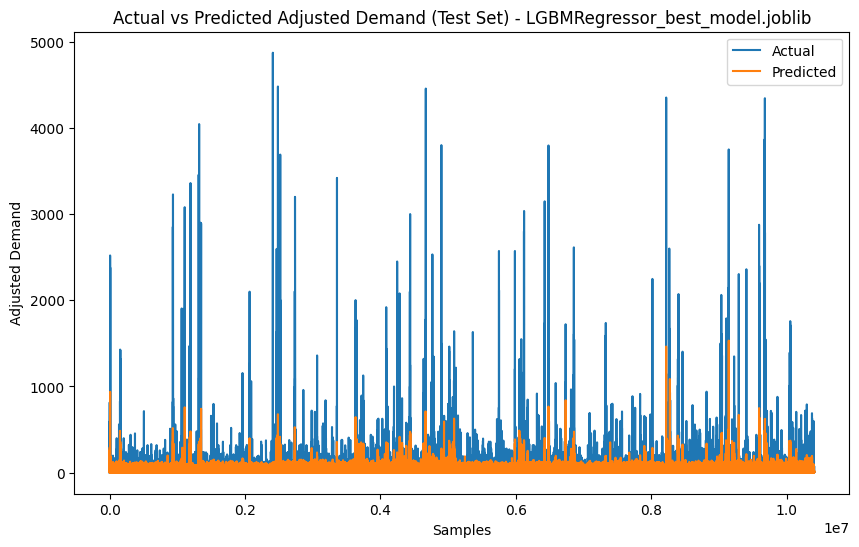

Loaded model from /kaggle/working/models/863991654058731718/XGBRegressor_best_model.joblib
Test MSE: 120.55318296520583
Test RMSE: 10.979671350509806
Test R-squared: 0.7486817128911408


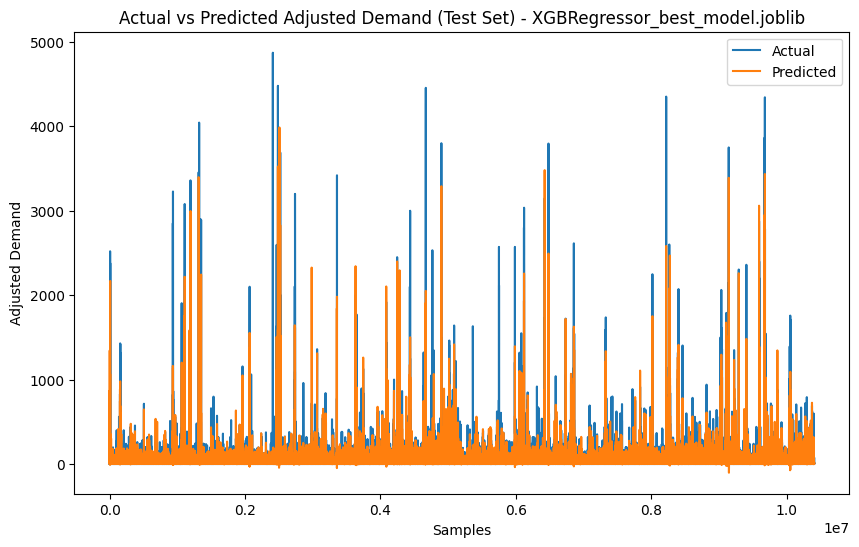

Loaded model from /kaggle/working/models/863991654058731718/CatBoostRegressor_best_model.joblib
Test MSE: 121.6279615447964
Test RMSE: 11.02850676858823
Test R-squared: 0.7464411124772807


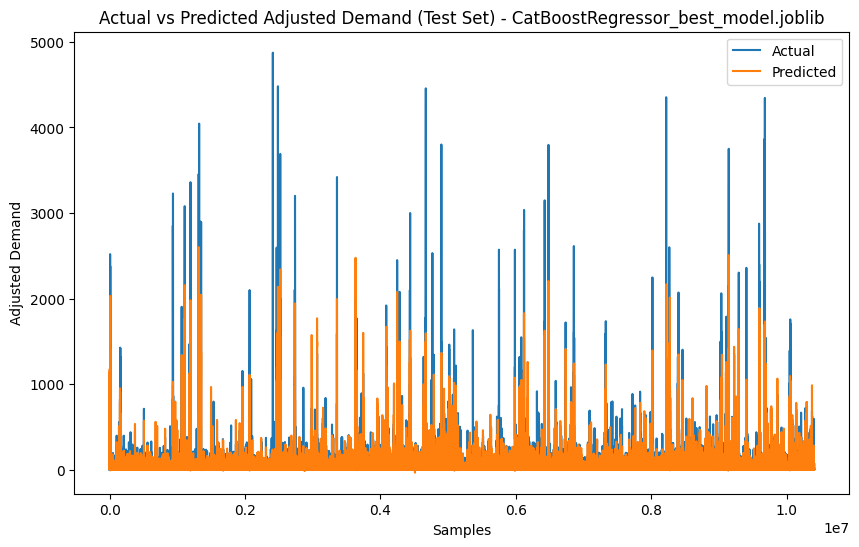

7428

In [34]:
check = pd.DataFrame()
def load_and_evaluate_models(model_directory, X_test, y_test,experiment_id):
    """Evaluation the Performance of Various Model using Test Data"""
    # List all files in the model directory
    print(os.listdir(os.path.join(model_directory,experiment_id)))
    model_files = [f for f in os.listdir(os.path.join(model_directory,experiment_id)) if f.endswith('.joblib')]
    # Iterate over the found model files
    for model_file in model_files:
        # Load the model
        model_path = os.path.join(model_directory, experiment_id, model_file)
        model = joblib.load(model_path)
        print(f"Loaded model from {model_path}")

        # Predict on the test set
        y_test_pred = model.predict(X_test)
        y_test = y_test.astype(float)
        y_test_pred = y_test_pred.astype(float)
        # Evaluate the model on the test set
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_test_pred)
        print(f'Test MSE: {test_mse}')
        print(f'Test RMSE: {test_rmse}')
        print(f'Test R-squared: {test_r2}')
        # Plot actual vs predicted values for test set
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.values, label='Actual')
        plt.plot(y_test_pred, label='Predicted')
        plt.title(f'Actual vs Predicted Adjusted Demand (Test Set) - {model_file}')
        plt.xlabel('Samples')
        plt.ylabel('Adjusted Demand')
        plt.legend()
        plt.show()
    del model
#     del y_test_pred
model_directory = CFG.MODEL_SAVE_PATH
load_and_evaluate_models(model_directory, X_test, y_test,experiment_id)
# Cleanup after execution
del X_train
del y_train
gc.collect()

<a id="5.4"></a>
### <b>5.4 <span style='color:#E1B12D'> Ensembling for Performance Improvement </span></b> 

In [35]:
def load_models(model_directory):
    """Load all models from the specified directory."""
    models = {}
    for model_name in ['XGBRegressor_best', 'CatBoostRegressor_best']:
        file_path = os.path.join(model_directory, f"{model_name}_model.joblib")
        models[model_name] = joblib.load(file_path)
    return models

# Directory where models are saved
model_directory = '/kaggle/working/models/' + experiment_id

# Load models
models = load_models(model_directory)

def objective(trial):
    """Enhance the performance of ensembling and optimizing weights."""
    # Suggest weights for each model
    w_catboost = trial.suggest_float('w_catboost', 0, 1)
    w_xgboost = trial.suggest_float('w_xgboost', 0, 1)
    
    # Normalize weights so they sum to 1
    total = w_catboost + w_xgboost
    w_catboost /= total
    w_xgboost /= total
    
    # Collect individual model predictions
    y_pred_cat = models['CatBoostRegressor_best'].predict(X_test)
    y_pred_xgb = models['XGBRegressor_best'].predict(X_test)

    # Combine predictions based on the weights
    y_pred = (w_catboost * y_pred_cat + w_xgboost * y_pred_xgb)

    # Calculate and return the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Retrieve the best weights
best_weights = {
    'CatBoostRegressor_best': study.best_trial.params['w_catboost'],
    'XGBRegressor_best': study.best_trial.params['w_xgboost']
}
total = sum(best_weights.values())
best_weights = {model: weight / total for model, weight in best_weights.items()}
print("Best weights:", best_weights)

[I 2024-07-07 09:14:18,150] A new study created in memory with name: no-name-63e68e54-1707-41cb-a110-62906749e927
[I 2024-07-07 09:15:10,826] Trial 0 finished with value: 10.622469527902028 and parameters: {'w_catboost': 0.8887103196309347, 'w_xgboost': 0.3572288245323836}. Best is trial 0 with value: 10.622469527902028.
[I 2024-07-07 09:16:03,404] Trial 1 finished with value: 10.524013906020945 and parameters: {'w_catboost': 0.6585255367086637, 'w_xgboost': 0.7870309808648064}. Best is trial 1 with value: 10.524013906020945.
[I 2024-07-07 09:16:56,322] Trial 2 finished with value: 10.522756307393792 and parameters: {'w_catboost': 0.8175569407239766, 'w_xgboost': 0.9284726133734461}. Best is trial 2 with value: 10.522756307393792.
[I 2024-07-07 09:17:49,141] Trial 3 finished with value: 10.523273712473793 and parameters: {'w_catboost': 0.6107929306432095, 'w_xgboost': 0.7106386505794141}. Best is trial 2 with value: 10.522756307393792.
[I 2024-07-07 09:18:42,193] Trial 4 finished with 

Best weights: {'CatBoostRegressor_best': 0.4682377447766612, 'XGBRegressor_best': 0.5317622552233388}


In [36]:
def predict_ensemble(X_test, model_directory, best_weights):
    """Make predictions using an ensemble of pre-trained models and specified weights."""
    models = load_models(model_directory)
    # Collect individual model predictions
    y_pred_cat = models['CatBoostRegressor_best'].predict(X_test)
    y_pred_lgb = models['XGBRegressor_best'].predict(X_test)

    # Combine predictions based on the weights
    y_pred = (best_weights['CatBoostRegressor_best'] * y_pred_cat +
              best_weights['XGBRegressor_best'] * y_pred_lgb)
    return y_pred

<a id="5.5"></a>
### <b>5.5 <span style='color:#E1B12D'> Model Explainablity </span></b> 

Explaining model: XGBRegressor_best


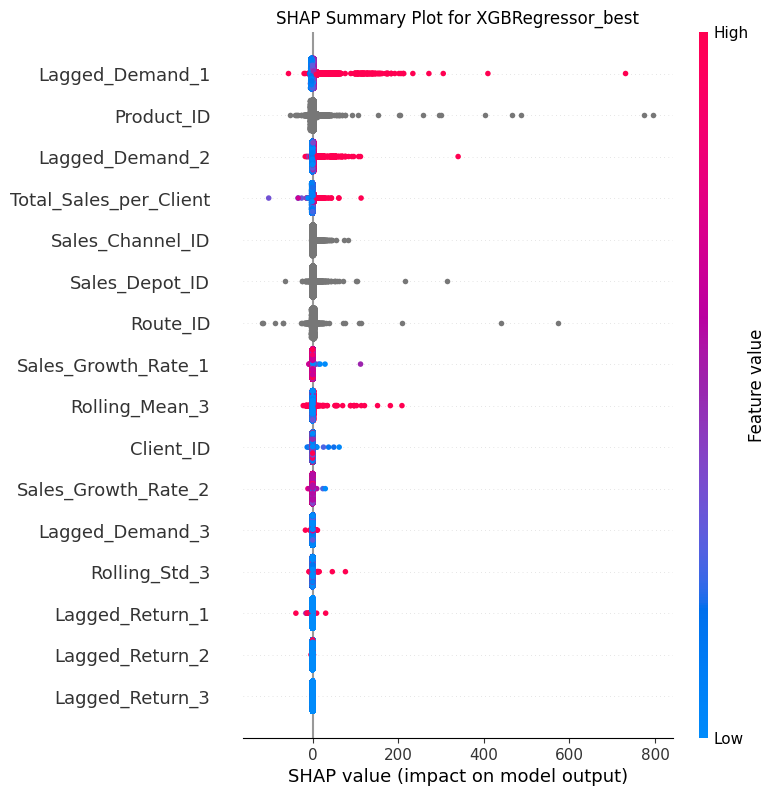

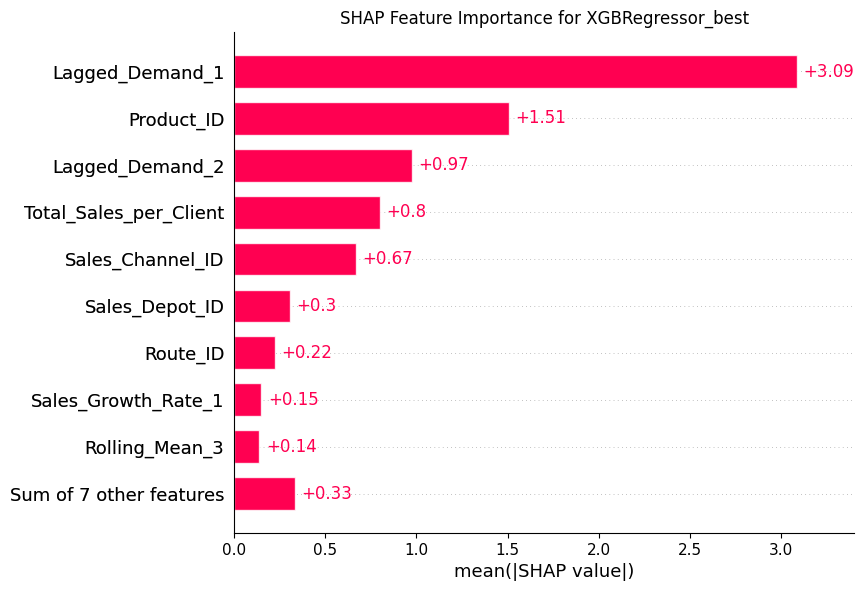

Explaining model: CatBoostRegressor_best


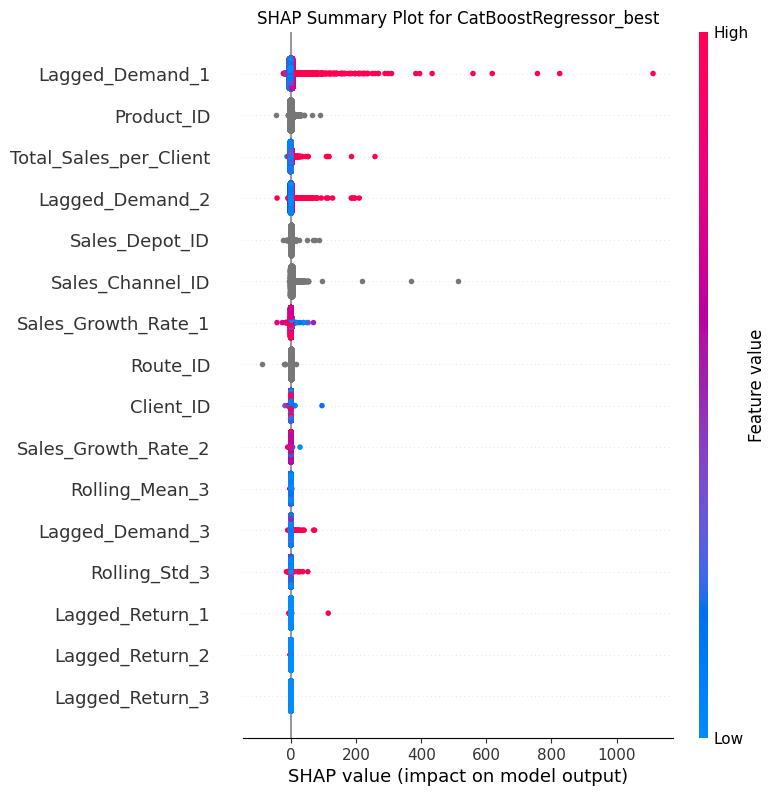

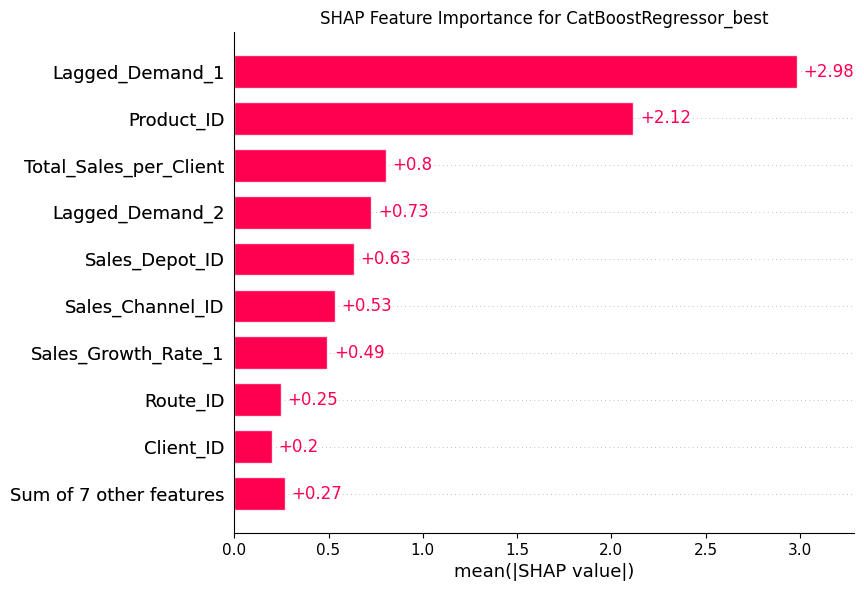

In [37]:
def model_explainability(model_directory, X_test):
    """Provide the importance of Features in the Model"""
    shap_values_dict = {}
    X_test_sampled = X_test.sample(frac=0.005)  # Ensure variable naming consistency
    models = load_models(model_directory)
    for name, model in models.items():
        print(f"Explaining model: {name}")
        if 'catboost' in name.lower():
            explainer = shap.TreeExplainer(model, feature_perturbation='interventional', check_additivity=False)
            shap_values = explainer(X_test_sampled, check_additivity=False)
        elif 'xgb' in name.lower() or 'lgbm' in name.lower():
            explainer = shap.TreeExplainer(model, check_additivity=False)
            shap_values = explainer(X_test_sampled, check_additivity=False)
        else:
            explainer = shap.Explainer(model, feature_perturbation='interventional', check_additivity=False)
            shap_values = explainer(X_test_sampled)
        
        shap_values_dict[name] = shap_values
        
        # Plot summary plot for the current model
        shap.summary_plot(shap_values, X_test_sampled, show=False)
        plt.title(f"SHAP Summary Plot for {name}")
        plt.show()
        
        # Plot feature importance bar chart for the current model
        shap.plots.bar(shap_values, show=False)
        plt.title(f"SHAP Feature Importance for {name}")
        plt.show()
    
    return shap_values_dict

# Example usage
shap_values_dict = model_explainability(model_directory, X_test)

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
<a id="6"></a>
## <b>6 <span style='color:#E1B12D'> Model Inference </span></b> 
<a id="6.1"></a>
### <b>6.1 <span style='color:#E1B12D'> Loading the Model </span></b> 

In [38]:
def predict_ensemble(X_test, model_directory, best_weights):
    """Make predictions using an ensemble of pre-trained models and specified weights."""
    models = load_models(model_directory)
    # Collect individual model predictions
    y_pred_cat = models['CatBoostRegressor_best'].predict(X_test)
    y_pred_lgb = models['XGBRegressor_best'].predict(X_test)

    # Combine predictions based on the weights
    y_pred = (best_weights['CatBoostRegressor_best'] * y_pred_cat +
              best_weights['XGBRegressor_best'] * y_pred_lgb)
    return y_pred

<a id="6.2"></a>
### <b>6.2 <span style='color:#E1B12D'> Data Loading and Prepration </span></b> 
#### 6.2.1 Reading the data

In [39]:
def read_filtered_csv(file_path, Week, chunksize=10000000):
    """ Reading the data in chunks"""
    filtered_df = pd.DataFrame()
    filter_condition = lambda df: df['Semana'] >= Week-2
    for chunk in pd.read_csv(file_path, compression='zip', chunksize=chunksize):
        # Apply the filter condition
        filtered_chunk = chunk[filter_condition(chunk)]
        # Append the filtered chunk to the final DataFrame
        filtered_df = pd.concat([filtered_df, filtered_chunk], ignore_index=True)
    return filtered_df
test_df = read_filtered_csv(CFG.TRAIN_PATH,9 , chunksize=10000000)

#### 6.2.2 Processing the Data

In [40]:
def processing_for_prediction(df,week):
    df = prepare_data(df)
    df = pipeline.fit_transform(df)
    week_for_prediction = pd.to_datetime('2024-01-01') + pd.to_timedelta(week * 7, unit='D')
    df = df[df.index == week_for_prediction]
    df = df.drop('Adjusted_Demand',axis = 1)
    return df

In [41]:
test_df = processing_for_prediction(test_df,9)

Decreased by 58.0%
Decreased by 17.4%
Decreased by 14.8%
Decreased by 2.2%
Decreased by 33.7%


<a id="6.3"></a>
### <b>6.3 <span style='color:#E1B12D'> Model Forecasting </span></b> 

In [42]:
def prediction(df):
    y_pred = predict_ensemble(df, model_directory, best_weights)
    df['Forecasted Demand'] = y_pred
    return df

In [43]:
test_df = prediction(test_df)
test_df.head(1000).to_csv('Forecasted_demand.csv', index=False)

### Mlflow Local UI

In [44]:
if CFG.EXPERIMENT_RECORDING == 'LOCAL':
    !pip install mlflow --quiet
    !pip install pyngrok --quiet
    
    from pyngrok import ngrok
    from getpass import getpass

    ngrok.kill()

    # Setting the authtoken (replace with your own token from https://dashboard.ngrok.com/auth)
    NGROK_AUTH_TOKEN = "2ioyKWLGBeFWH5D7vI5ktAJaZSV_2aUaXGdGJeHsk43qWXRvk"
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Start the MLflow UI
    get_ipython().system_raw("mlflow ui --backend-store-uri file:/kaggle/working/mlflow --host 0.0.0.0 --port 5000 &")

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://f9c5-34-141-226-213.ngrok-free.app                                      


[2024-07-07 09:30:27 +0000] [338] [INFO] Starting gunicorn 22.0.0
[2024-07-07 09:30:27 +0000] [338] [INFO] Listening at: http://0.0.0.0:5000 (338)
[2024-07-07 09:30:27 +0000] [338] [INFO] Using worker: sync
[2024-07-07 09:30:27 +0000] [339] [INFO] Booting worker with pid: 339
[2024-07-07 09:30:27 +0000] [340] [INFO] Booting worker with pid: 340
[2024-07-07 09:30:27 +0000] [341] [INFO] Booting worker with pid: 341
[2024-07-07 09:30:27 +0000] [342] [INFO] Booting worker with pid: 342
